In [2]:
# base instruments
import numpy as np 
import pandas as pd 
import os
# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
# models
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
# training and tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
# metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [3]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    #fit_times_mean = np.mean(fit_times, axis=1)
    #fit_times_std = np.std(fit_times, axis=1)
    
    if scoring=='neg_log_loss':
        train_scores_mean*=-1
        test_scores_mean*=-1

    # Plot learning curve
    axes.grid()
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes.legend(loc="best")

    return plt

In [4]:
PATH = './'
RANDOM_STATE = 42

In [5]:
files = [f for f in os.listdir(PATH) if os.path.isfile(f)]
for f in files:
    print(f)

.gitattributes
.gitignore
test.csv
titanic-survivor-classifier-Copy1.ipynb
titanic-survivor-classifier.ipynb
train.csv


In [6]:
df = pd.read_csv('train.csv')

### EDA part

In [7]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


So, how much NaN values we have?

In [9]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
print("Age fullness is ", df['Age'].notna().mean())
print("Cabin fullness is ", df['Cabin'].notna().mean())
print("Embarked fullness is ", df['Embarked'].notna().mean())

Age fullness is  0.8013468013468014
Cabin fullness is  0.22895622895622897
Embarked fullness is  0.9977553310886644


In [11]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Missed Embarked value replace by most common

In [12]:
df['Embarked'].fillna('S', inplace=True)

Cabin-column can be deleted, because it fullness is too low and may be something not relevant like Id. And PassangerId like not relevant, maybe random number. The same way - Ticket column

In [13]:
data = df.drop(["Cabin", "PassengerId", "Ticket"] , axis=1)

In [14]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [15]:
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Age and suvival relationship

array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

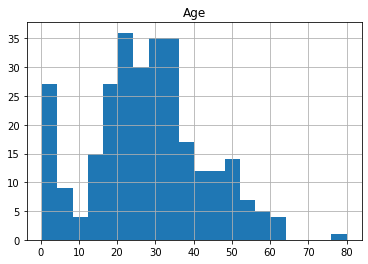

In [16]:
df.query("Survived == 1").hist(column = "Age" , bins=20)

array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

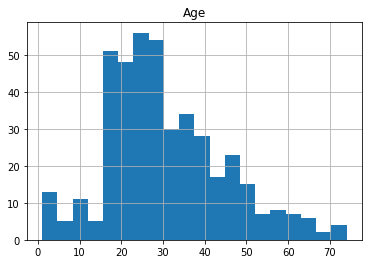

In [17]:
df.query("Survived == 0").hist(column = "Age" , bins=20)

Also for Fare

array([[<AxesSubplot:title={'center':'Fare'}>]], dtype=object)

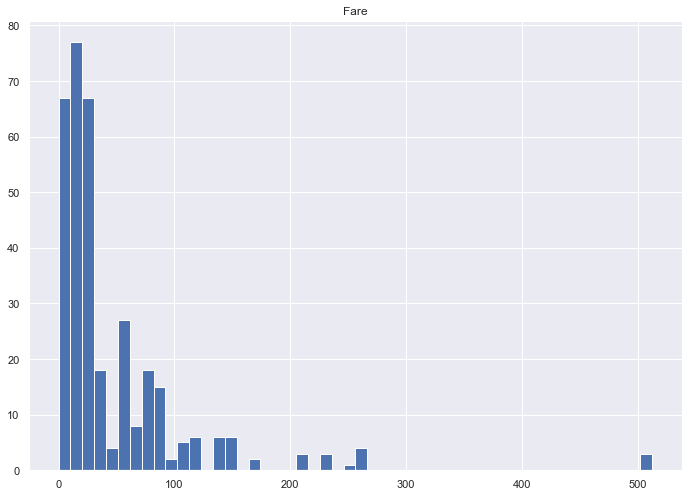

In [102]:
df.query("Survived == 1").hist(column = "Fare" , bins=50)

array([[<AxesSubplot:title={'center':'Fare'}>]], dtype=object)

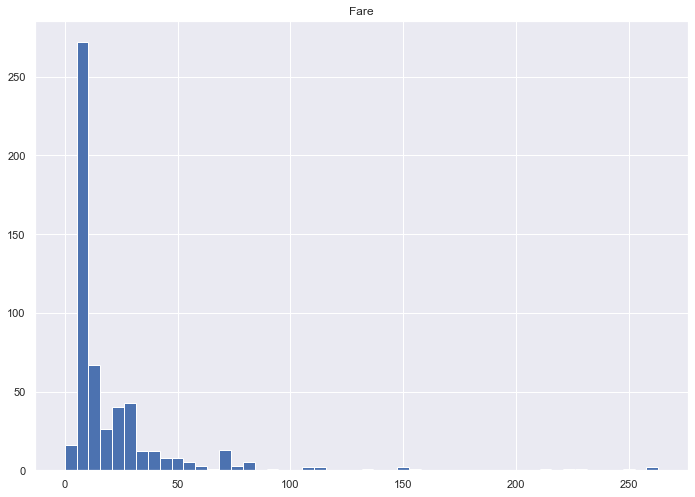

In [103]:
df.query("Survived == 0").hist(column = "Fare" , bins=50)

Male survival


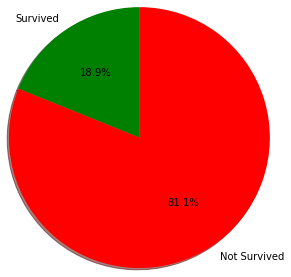

In [18]:
activities = ["Survived", "Not Survived"]

slices = [df.query("Sex == 'male' & Survived==1 ")["Survived"].count(),
          df.query("Sex == 'male' & Survived==0")["Survived"].count()]

colors = ['g', 'r']

# plotting the pie chart
plt.pie(slices, labels=activities, colors=colors,
        startangle=90, shadow=True,
        radius=1.5, autopct='%1.1f%%')


print("Male survival")

plt.show()

Female survival


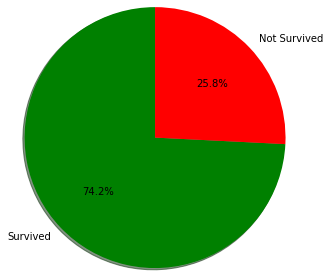

In [19]:
activities = ["Survived", "Not Survived"]

slices = [df.query("Sex == 'female' & Survived==1 ")["Survived"].count(),
          df.query("Sex == 'female' & Survived==0")["Survived"].count()]

colors = ['g', 'r']

# plotting the pie chart
plt.pie(slices, labels=activities, colors=colors,
        startangle=90, shadow=True,
        radius=1.5, autopct='%1.1f%%')


print("Female survival")

plt.show()

### Feature engineering part

Let's extract some information from names of passagers

\
**1)** Firstly we can extract number of symbols and words from names

In [20]:
data["Name_len"] = data["Name"].apply(len)
data["Num_of_name_tokens"] = data["Name"].apply(lambda name: len(name.split()))

In [21]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Name_len,Num_of_name_tokens
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,23,4
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,51,7
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,22,3
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,44,7
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,24,4


In [22]:
s = (" ".join(data["Name"])).split()


In [23]:
pd.value_counts(s)[:25]

Mr.          517
Miss.        182
Mrs.         125
William       62
John          44
Master.       40
Henry         33
James         24
Charles       23
George        22
Thomas        21
Edward        18
Joseph        16
Johan         15
Frederick     15
Richard       13
Samuel        13
Mary          13
Arthur        13
Alfred        12
Anna          11
Jr            10
Karl           9
Peter          9
Alexander      9
dtype: int64

\
**2)** So, as we can see, great number of passengers have status tokens in their names - like "Mr." and another. Let's extract them.

In [24]:
data["Name"].str.extract(' ([A-Za-z]+)\.').value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Mme           1
Ms            1
Capt          1
Lady          1
Jonkheer      1
Don           1
Countess      1
Sir           1
dtype: int64

For escaping of extrafeatures let's delete some single(1-3 times) examples and replace them marker 'Rare'. Alse correct some analogues for Miss and Mrs

In [25]:
rare_stat = ["Capt", "Lady", "Jonkheer", "Don", "Countess", "Sir", "Major", "Col", "Dona"]
data["Status"] = (data["Name"].str.extract(' ([A-Za-z]+)\.')).replace(rare_stat, "Rare")\
                                                             .replace({"Mlle": "Miss",
                                                                       "Ms": "Miss",
                                                                       "Mme": "Mrs"})

P.S. "Dona" added to list for the submission data

In [26]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Name_len,Num_of_name_tokens,Status
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,23,4,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,51,7,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,22,3,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,44,7,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,24,4,Mr


\
**3)** Let's add age category

In [27]:
data.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [28]:
def age_stat(age):
    if age < 14:
        return "Child"
    elif age < 30:
        return "Young"
    elif age < 50:
        return "Adult"
    else:
        return "Old"

In [29]:
data["Age_category"] = data.Age.agg(age_stat)

In [30]:
data["Age_category"].value_counts()

Young    313
Adult    256
Old      251
Child     71
Name: Age_category, dtype: int64

\
**4)** Let also flag if passanger without family on a board

In [31]:
data["Is_alone"] = ((data.Parch + data.SibSp) == 0) * 1

In [32]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Name_len,Num_of_name_tokens,Status,Age_category,Is_alone
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,23,4,Mr,Young,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,51,7,Mrs,Adult,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,22,3,Miss,Young,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,44,7,Mrs,Adult,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,24,4,Mr,Adult,1


Delete 1 value after OHE-encoding

In [33]:
X = (pd.get_dummies(data.drop(["Name", "Survived"], axis=1))).drop(["Sex_female", "Embarked_Q", "Age_category_Child"], axis=1)
X.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Name_len',
       'Num_of_name_tokens', 'Is_alone', 'Sex_male', 'Embarked_C',
       'Embarked_S', 'Status_Dr', 'Status_Master', 'Status_Miss', 'Status_Mr',
       'Status_Mrs', 'Status_Rare', 'Status_Rev', 'Age_category_Adult',
       'Age_category_Old', 'Age_category_Young'],
      dtype='object')

In [34]:
y = data["Survived"]

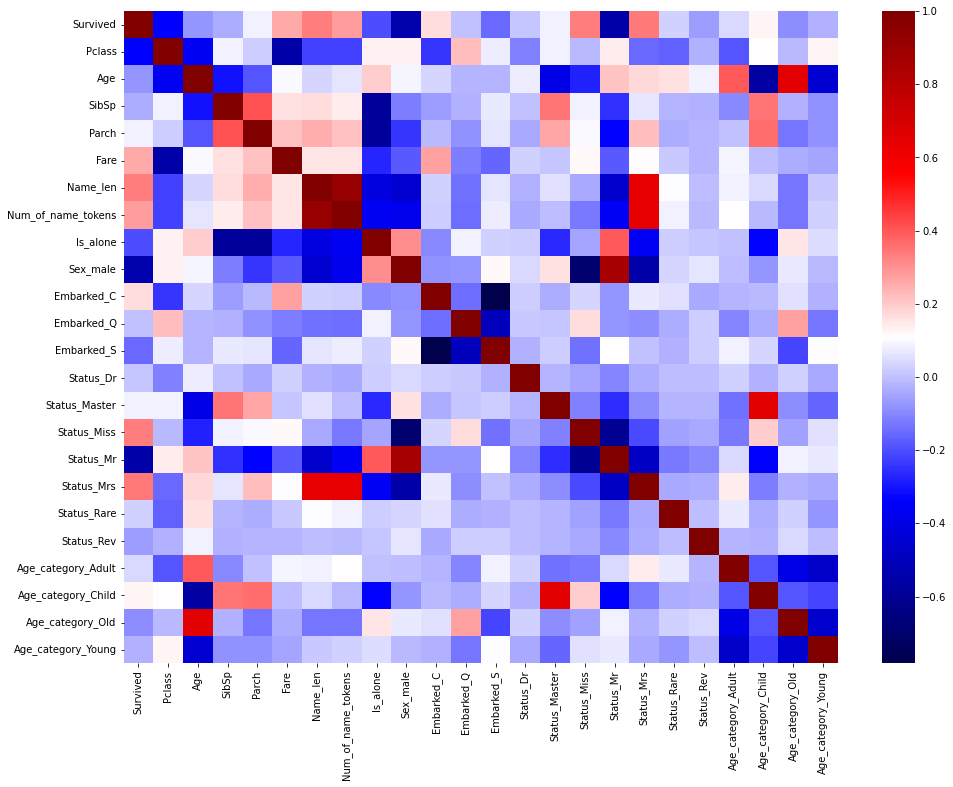

In [35]:
corr = (pd.get_dummies(data.drop("Name", axis=1))).drop("Sex_female", axis=1).corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr, cmap="seismic")
plt.show()

In [36]:
len(X.columns)

21

### Training/Valid part

#### Bosting

Main model will be **Bossting** from lightgbm

In [230]:
params_boost = {'n_estimators':100,
                'reg_alpha': 5,
                'reg_lambda': 5}

In [231]:
cv = KFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)

train_score = []
valid_score = []

for fold, (train_index, test_index) in enumerate(cv.split(X)):

    print("Fold #{}".format(fold))

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = lgb.LGBMClassifier(**params_boost, n_jobs=4)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              eval_metric='logloss', early_stopping_rounds=4, verbose=0)
    results = model.evals_result_
    
    train_score.append(results['training']['binary_logloss'][-1])
    valid_score.append(results['valid_1']['binary_logloss'][-1])
    

Fold #0
Fold #1
Fold #2
Fold #3


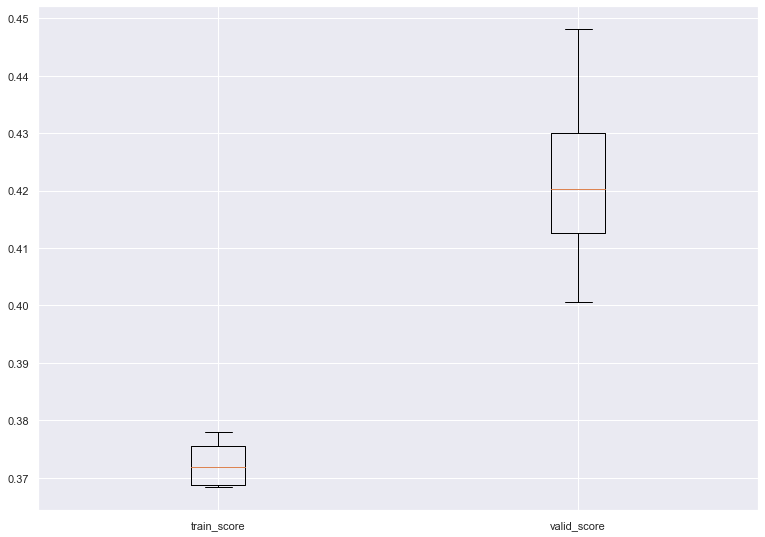

In [232]:
data = [train_score, valid_score]
fig = plt.figure(figsize=(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)

ax.set_xticklabels(["train_score", "valid_score"])

plt.show()

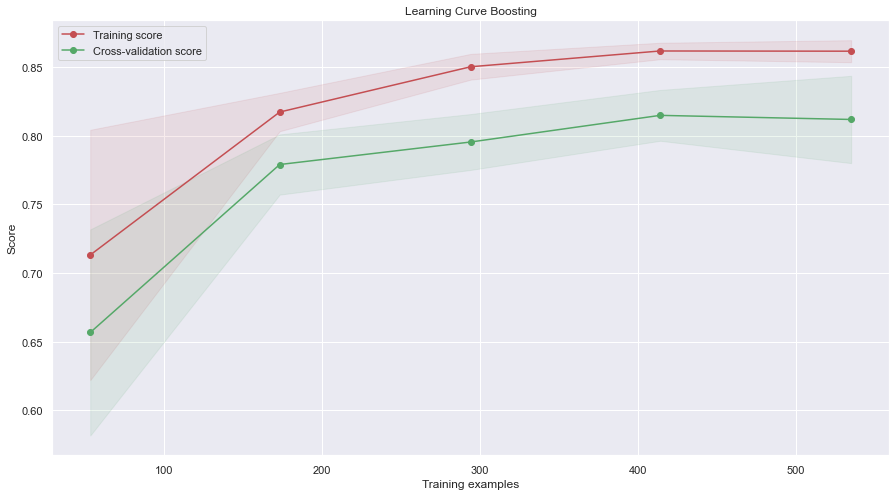

In [233]:
fig, axes = plt.subplots(1, 1, figsize=(15, 8))

title = "Learning Curve Boosting"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(lgb.LGBMClassifier(**params_boost, n_jobs=4),
    title, X_train, y_train, axes=axes, cv=cv, n_jobs=4, scoring='accuracy')

plt.grid()
plt.show()

In [234]:
model = lgb.LGBMClassifier(**params_boost, n_jobs=4)

In [235]:
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='accuracy', early_stopping_rounds=4, verbose=0)

LGBMClassifier(n_jobs=4, reg_alpha=5, reg_lambda=5)

In [236]:
results = model.evals_result_

In [237]:
train_scores = results['training']['binary_logloss']
val_scores = results['valid_1']['binary_logloss']

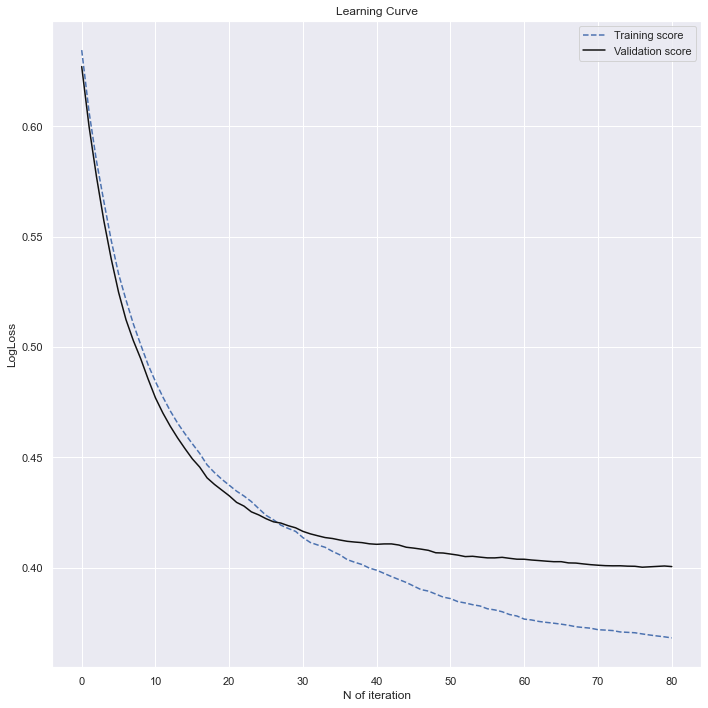

In [238]:
iters = [i for i in range(len(train_scores))]
plt.subplots(figsize=(10, 10))
plt.plot(iters, train_scores, '--',
         label="Training score")
plt.plot(iters, val_scores, color="#111111",
         label="Validation score")

plt.title("Learning Curve")
plt.xlabel("N of iteration"), plt.ylabel(
    "LogLoss"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='importance_split', ylabel='name'>

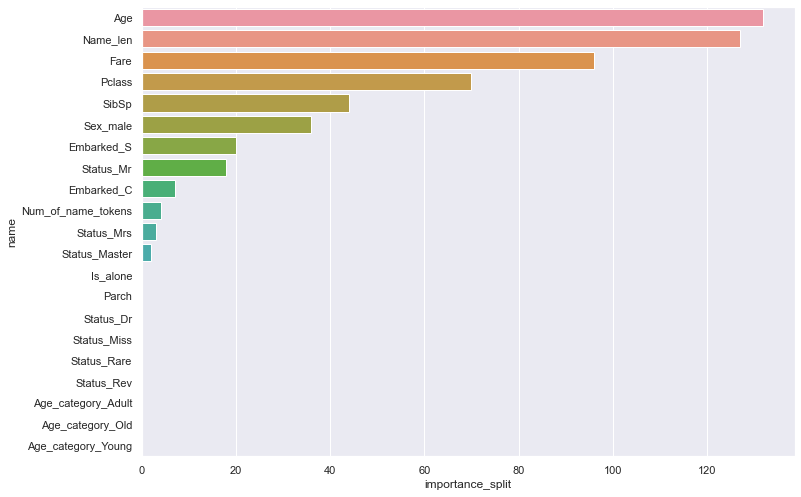

In [239]:
fimp = pd.DataFrame({"name": X_train.columns,
                    "importance_split": model.booster_.feature_importance(importance_type='split')})
sns.set(rc={"figure.figsize": (11.7, 8.27)})
sns.barplot(y="name", x="importance_split",
            data=fimp.sort_values(by="importance_split", ascending=False))

<AxesSubplot:xlabel='importance_gain', ylabel='name'>

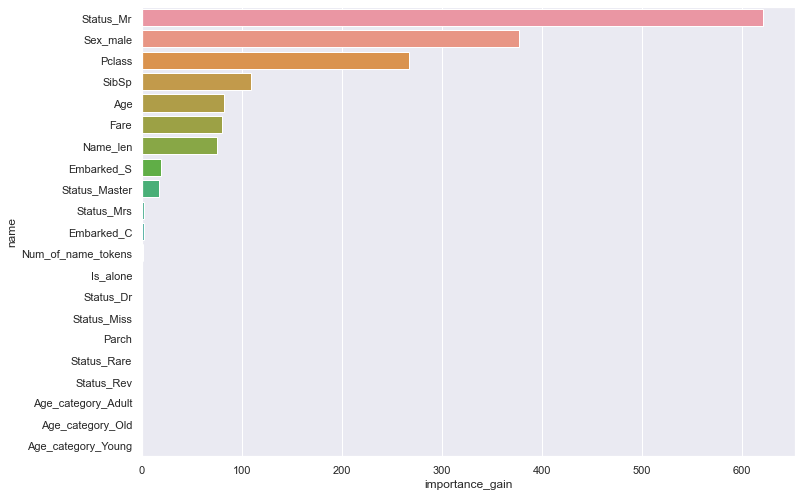

In [240]:
fimp = pd.DataFrame({"name": X_train.columns,
                    "importance_gain": model.booster_.feature_importance(importance_type='gain')})
sns.set(rc={"figure.figsize": (11.7, 8.27)})
sns.barplot(y="name", x="importance_gain",
            data=fimp.sort_values(by="importance_gain", ascending=False))

#### Random Forest

And another model will be **Random Forest**

In [206]:
params2 = {'max_depth':5,
           'n_estimators':100}

In [207]:
model2 = RandomForestClassifier(**params2, n_jobs = 4)

RandomForest doesn't support NaN values. So, let's replace them

In [208]:
X.isna().sum()

Pclass                  0
Age                   177
SibSp                   0
Parch                   0
Fare                    0
Name_len                0
Num_of_name_tokens      0
Is_alone                0
Sex_male                0
Embarked_C              0
Embarked_S              0
Status_Dr               0
Status_Master           0
Status_Miss             0
Status_Mr               0
Status_Mrs              0
Status_Rare             0
Status_Rev              0
Age_category_Adult      0
Age_category_Old        0
Age_category_Young      0
dtype: int64

In [209]:
X_rf = X.fillna(value = -99)
#X_rf = X.fillna(value = X['Age'].mean())

In [210]:
cv = KFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)

train_score = []
valid_score = []

for fold, (train_index, test_index) in enumerate(cv.split(X)):

    print("Fold #{}".format(fold))

    X_train, X_test = X_rf.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = lgb.LGBMClassifier(**params2, n_jobs=4)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              eval_metric='logloss', early_stopping_rounds=4, verbose=0)
    results = model.evals_result_
    
    train_score.append(results['training']['binary_logloss'][-1])
    valid_score.append(results['valid_1']['binary_logloss'][-1])
    

Fold #0
Fold #1
Fold #2
Fold #3


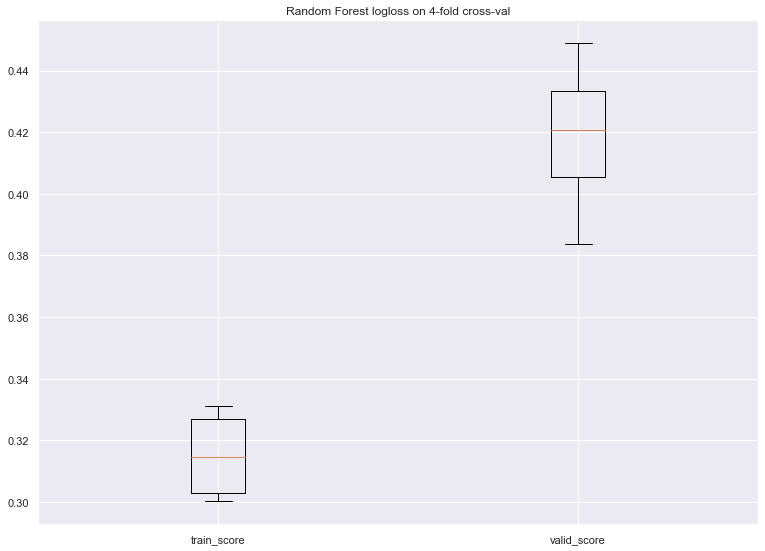

In [211]:
data = [train_score, valid_score]
fig = plt.figure(figsize=(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)

ax.set_xticklabels(["train_score", "valid_score"])

plt.title("Random Forest logloss on 4-fold cross-val")

plt.show()

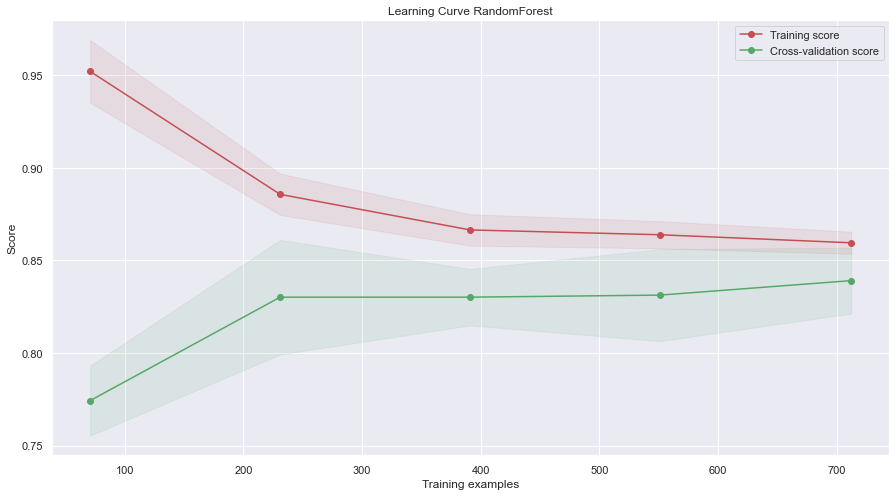

In [212]:
fig, axes = plt.subplots(1, 1, figsize=(15, 8))

title = "Learning Curve RandomForest"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
plot_learning_curve(model2, title, X_rf, y,
                    axes=axes, cv=cv, n_jobs=4, scoring='accuracy')
plt.grid()

In [205]:
model2 = RandomForestClassifier(**params2, random_state=42)

In [189]:
model2.fit(X_rf, y)

RandomForestClassifier(max_depth=5, n_estimators=2000, random_state=42)

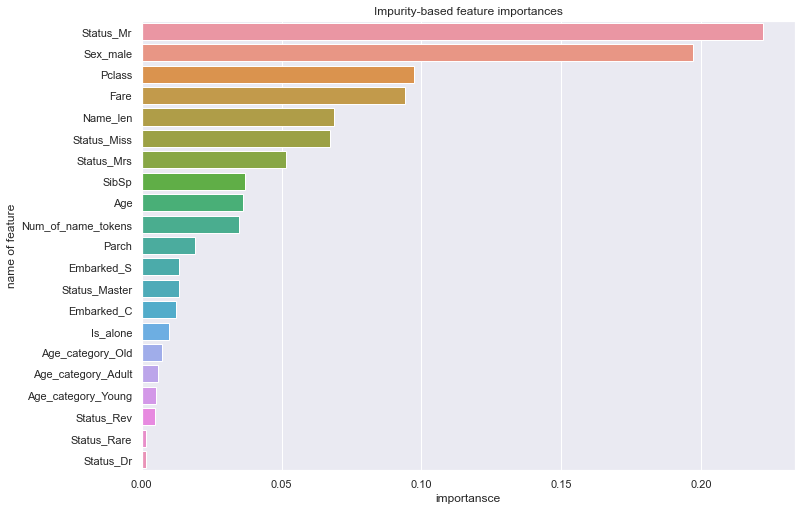

In [190]:
fimp = pd.DataFrame({"name of feature": X_rf.columns,
                    "importansce": model2.feature_importances_})
sns.set(rc={"figure.figsize": (11.7, 8.27)})
sns.barplot(y="name of feature", x="importansce",  data=fimp.sort_values(
    by="importansce", ascending=False)).set(title='Impurity-based feature importances')
plt.show()

### Submission part

In [155]:
df_test = pd.read_csv('test.csv')

In [173]:
df_test.shape

(418, 16)

In [156]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [157]:
df_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [158]:
df_test["Fare"].fillna(df["Fare"].median(), inplace = True)

**Repeat all FE actions**

In [159]:
df_test["Name_len"] = df_test["Name"].apply(len)
df_test["Num_of_name_tokens"] = df_test["Name"].apply(lambda name: len(name.split()))

In [160]:
df_test["Name"].str.extract(' ([A-Za-z]+)\.').value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dona        1
Dr          1
Ms          1
dtype: int64

In [161]:
rare_stat

['Capt', 'Lady', 'Jonkheer', 'Don', 'Countess', 'Sir', 'Major', 'Col', 'Dona']

In [162]:
df_test["Status"] = (df_test["Name"].str.extract(' ([A-Za-z]+)\.')).replace(rare_stat, "Rare")\
                                                                   .replace({"Mlle": "Miss",
                                                                             "Ms": "Miss",
                                                                             "Mme": "Mrs"})

In [163]:
df_test["Status"].value_counts()

Mr        240
Miss       79
Mrs        72
Master     21
Rare        3
Rev         2
Dr          1
Name: Status, dtype: int64

In [164]:
df_test["Age_category"] = df_test.Age.agg(age_stat)

In [165]:
df_test["Is_alone"] = ((df_test.Parch + df_test.SibSp) == 0) * 1

In [166]:
X_score = (pd.get_dummies(df_test.drop(["Name", "PassengerId", "Ticket", "Cabin"], axis=1))) \
          .drop(["Sex_female", "Embarked_Q", "Age_category_Child"], axis=1)

X_score.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Name_len',
       'Num_of_name_tokens', 'Is_alone', 'Sex_male', 'Embarked_C',
       'Embarked_S', 'Status_Dr', 'Status_Master', 'Status_Miss', 'Status_Mr',
       'Status_Mrs', 'Status_Rare', 'Status_Rev', 'Age_category_Adult',
       'Age_category_Old', 'Age_category_Young'],
      dtype='object')

In [167]:
len(X_score.columns)

21

In [168]:
X_score.isna().sum()

Pclass                 0
Age                   86
SibSp                  0
Parch                  0
Fare                   0
Name_len               0
Num_of_name_tokens     0
Is_alone               0
Sex_male               0
Embarked_C             0
Embarked_S             0
Status_Dr              0
Status_Master          0
Status_Miss            0
Status_Mr              0
Status_Mrs             0
Status_Rare            0
Status_Rev             0
Age_category_Adult     0
Age_category_Old       0
Age_category_Young     0
dtype: int64

In [169]:
preds = model2.predict(X_score.fillna(-99))
#preds = mdl.predict(X_score)

In [170]:
ids = df_test.PassengerId
submission_df = pd.DataFrame.from_dict({"PassengerId": ids, "Survived": preds})

In [171]:
submission_df.to_csv('submission.csv', index=False)

In [172]:
submission_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
